In [7]:
!pip install -q transformers accelerate peft bitsandbytes datasets sentencepiece openpyxl


In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
DATA_PATH = "/content/drive/MyDrive/Thesis/final data.xlsx"   # change if needed
OUTPUT_DIR = "/content/drive/MyDrive/Thesis/DialectLLM-Qwen2-0.5B"


In [10]:
import pandas as pd

df = pd.read_excel(DATA_PATH)
df.head()


,Promito,Rajshahi,Sylhet,Chottogram,Rangpur,Bogura,Noakhali,Barishal
0,তুমি কি করছো?,তুমি কী কইরছো,তুমি কিতা করো?,তুঁই কিরর ?,কি কইরবান নাকছেন তোমরা???,তুই ক্যা কত্ত্যাছিস?,তুঁই কিতা করর?,তুমি কি করতেছো?
1,তুমি কোথা থেকে আসছো?,কোতি থেকে অ্যাসছো?,তুমি কইথাকি আইছ?,তুঁই হত্তুন আইয়্যির ?,কোনটে থাকি আসচেন বাহে তোমরা?,তুই কনটি থাকি আসত্যাছিস?,তুঁই হোনডে ত্থন আইর?,তুমি কোথা দিয়া আইছো?
2,আপনি কোথায় যাচ্ছেন?,কতি জ্যাছেন?,আফনে কই যাইরাইন?,অনে হঁডে যর?,কোনটে জান বাহে তোমরা?,আঁরা কনটি যাত্ত্যাছেন?,আন্নে হোনডে যারেন?,আপনি কোথায় যান?
3,আপনার দিনকাল কেমন যাচ্ছে?,দিন ক্যামন জ্যাছে আপনার?,কিরম যায় বা তোমার দিন?,অঁনর দিনহাল ক্যান চলের ওয়া??,বাহে আপনার দিনকাল ক্যামনে যাচ্ছে?,আঁরার দিনকাল ক্যামন যাত্ত্যাছে?,আন্নের দিনকাল কেনে যার?,আপনার দিনকাল কেমন যাইতেছে?
4,আপনার সপ্তাহান্তের পরিকল্পনা কি?,সপ্তাহ শ্যাসে কি কইরবেন,আফনার সামনের সাপ্তাত পরিকল্পনা কিতা?,"ত, শুক্কু-শনিবারে কি গরিবে চিন্তে গইজ্জু??",বাহে আপনার সপ্তাহের পরিকল্পনা কি?,আঁরার সপ্তাহের শেষের পরিকল্পনা কি?,আন্নের হপ্তাহর শেষের পরিকল্পনা কিতা?,আপনার শনি-রবিবারের পরিকল্পনা কি?


In [11]:
dialect_columns = [
    "Rajshahi", "Sylhet", "Chottogram",
    "Rangpur", "Bogura", "Noakhali", "Barishal"
]

standard_col = "Promito"

rows = []
for _, row in df.iterrows():
    standard = row[standard_col]
    for d in dialect_columns:
        dialect_text = row[d]
        if isinstance(dialect_text, str) and isinstance(standard, str):
            if dialect_text.strip() and standard.strip():
                rows.append({
                    "dialect_name": d,
                    "dialect_text": dialect_text.strip(),
                    "standard_text": standard.strip()
                })

data_long = pd.DataFrame(rows)
len(data_long), data_long.head()

(14791,
   dialect_name               dialect_text  standard_text
 0     Rajshahi              তুমি কী কইরছো  তুমি কি করছো?
 1       Sylhet             তুমি কিতা করো?  তুমি কি করছো?
 2   Chottogram                তুঁই কিরর ?  তুমি কি করছো?
 3      Rangpur  কি কইরবান নাকছেন তোমরা???  তুমি কি করছো?
 4       Bogura       তুই ক্যা কত্ত্যাছিস?  তুমি কি করছো?)

In [12]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

train_df, temp_df = train_test_split(data_long, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
})

ds


DatasetDict({
    train: Dataset({
        features: ['dialect_name', 'dialect_text', 'standard_text'],
        num_rows: 11832
    })
    validation: Dataset({
        features: ['dialect_name', 'dialect_text', 'standard_text'],
        num_rows: 1479
    })
    test: Dataset({
        features: ['dialect_name', 'dialect_text', 'standard_text'],
        num_rows: 1480
    })
})

In [13]:
def format_example(example):
    instruction = (
        "### নির্দেশ:\n"
        "নিম্নের উপভাষার বাক্যটি প্রমিত বাংলায় রূপান্তর করো।\n"
        f"উপভাষা: {example['dialect_name']}\n"
        f"বাক্য: {example['dialect_text']}\n\n"
        "### উত্তর:\n"
        f"{example['standard_text']}"
    )
    return {"text": instruction}

ds = ds.map(format_example)
ds["train"][0]


Map:   0%|          | 0/11832 [00:00<?, ? examples/s]

Map:   0%|          | 0/1479 [00:00<?, ? examples/s]

Map:   0%|          | 0/1480 [00:00<?, ? examples/s]

{'dialect_name': 'Rangpur',
 'dialect_text': 'তাহলে তো খুব ভালো হয়।',
 'standard_text': 'তাহলে তো খুব ভালো হয়।',
 'text': '### নির্দেশ:\nনিম্নের উপভাষার বাক্যটি প্রমিত বাংলায় রূপান্তর করো।\nউপভাষা: Rangpur\nবাক্য: তাহলে তো খুব ভালো হয়।\n\n### উত্তর:\nতাহলে তো খুব ভালো হয়।'}

In [14]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model_name = "Qwen/Qwen2-0.5B"  # you can change if needed

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)


In [15]:
MAX_LENGTH = 256

def tokenize_function(example):
    return tokenizer(
        example["text"],
        max_length=MAX_LENGTH,
        truncation=True,
        padding="max_length",
    )

tokenized_ds = ds.map(
    tokenize_function,
    batched=True,
    remove_columns=ds["train"].column_names,  # remove original text cols
)

tokenized_ds


Map:   0%|          | 0/11832 [00:00<?, ? examples/s]

Map:   0%|          | 0/1479 [00:00<?, ? examples/s]

Map:   0%|          | 0/1480 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 11832
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1479
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1480
    })
})

In [16]:
def add_labels(example):
    example["labels"] = example["input_ids"].copy()
    return example

tokenized_ds = tokenized_ds.map(add_labels, batched=False)
tokenized_ds["train"][0].keys()


Map:   0%|          | 0/11832 [00:00<?, ? examples/s]

Map:   0%|          | 0/1479 [00:00<?, ? examples/s]

Map:   0%|          | 0/1480 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [17]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],  # common for transformer blocks
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 540,672 || all params: 494,573,440 || trainable%: 0.1093


In [18]:
OUTPUT_DIR = "/content/drive/MyDrive/Thesis/DialectLLM-Qwen2-0.5B"
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    learning_rate=2e-4,
    logging_steps=50,
    save_steps=500,
    # remove evaluation_strategy and eval_steps if unsupported
    # you can still run eval manually using trainer.evaluate()
    save_total_limit=2,
    fp16=True,
    # remove report_to if unsupported
)

In [21]:
from transformers import Trainer, TrainingArguments
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Re-defining model and tokenizer as they might not be defined from previous cells
model_name = "Qwen/Qwen2-0.5B"  # you can change if needed

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)

# Re-applying PEFT configuration
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],  # common for transformer blocks
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, peft_config)

# Re-creating ds and tokenized_ds for robustness, assuming data_long is defined
# This code is duplicated from previous cells to ensure `tokenized_ds` is defined

train_df, temp_df = train_test_split(data_long, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
})

def format_example(example):
    instruction = (
        "### নির্দেশ:\n"
        "নিম্নের উপভাষার বাক্যটি প্রমিত বাংলায় রূপান্তর করো.\n"
        f"উপভাষা: {example['dialect_name']}\n"
        f"বাক্য: {example['dialect_text']}\n\n"
        "### উত্তর:\n"
        f"{example['standard_text']}"
    )
    return {"text": instruction}

ds = ds.map(format_example)

MAX_LENGTH = 256

def tokenize_function(example):
    return tokenizer(
        example["text"],
        max_length=MAX_LENGTH,
        truncation=True,
        padding="max_length",
    )

tokenized_ds = ds.map(
    tokenize_function,
    batched=True,
    remove_columns=ds["train"].column_names,  # remove original text cols
)

def add_labels(example):
    example["labels"] = example["input_ids"].copy()
    return example

tokenized_ds = tokenized_ds.map(add_labels, batched=False)

# Define OUTPUT_DIR and training_args here for robustness
OUTPUT_DIR = "/content/drive/MyDrive/Thesis/DialectLLM-Qwen2-0.5B"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    learning_rate=2e-4,
    logging_steps=50,
    save_steps=500,
    save_total_limit=2,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
)

trainer.train()

Map:   0%|          | 0/11832 [00:00<?, ? examples/s]

Map:   0%|          | 0/1479 [00:00<?, ? examples/s]

Map:   0%|          | 0/1480 [00:00<?, ? examples/s]

Map:   0%|          | 0/11832 [00:00<?, ? examples/s]

Map:   0%|          | 0/1479 [00:00<?, ? examples/s]

Map:   0%|          | 0/1480 [00:00<?, ? examples/s]

Map:   0%|          | 0/11832 [00:00<?, ? examples/s]

Map:   0%|          | 0/1479 [00:00<?, ? examples/s]

Map:   0%|          | 0/1480 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ahmed15-5307 (ahmed15-5307-daffodil-international-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,2.079700
100,0.317300
150,0.265600
200,0.242400
250,0.237000
300,0.229600
350,0.227300
400,0.221200
450,0.218700
500,0.214500


TrainOutput(global_step=2220, training_loss=0.24262581677050205, metrics={'train_runtime': 4074.5557, 'train_samples_per_second': 8.712, 'train_steps_per_second': 0.545, 'total_flos': 1.9542747766063104e+16, 'train_loss': 0.24262581677050205, 'epoch': 3.0})

In [22]:
import torch

def generate_standard_from_dialect(dialect_sentence, dialect_name="Sylhet", max_new_tokens=64):
    prompt = (
        "### নির্দেশ:\n"
        "নিম্নের উপভাষার বাক্যটি প্রমিত বাংলায় রূপান্তর করো।\n"
        f"উপভাষা: {dialect_name}\n"
        f"বাক্য: {dialect_sentence}\n\n"
        "### উত্তর:\n"
    )
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            num_beams=4,
            eos_token_id=tokenizer.eos_token_id,
        )
    full_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    # Extract only the answer after "### উত্তর:"
    if "### উত্তর:" in full_text:
        return full_text.split("### উত্তর:")[-1].strip()
    else:
        return full_text

# Example:
print(
    generate_standard_from_dialect("তুমি কিতা করো?", dialect_name="Sylhet")
)


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


তুমি কি করো?


In [23]:
!pip install -q sacrebleu

import sacrebleu

def evaluate_bleu(num_samples=50):
    subset = ds["test"].shuffle(seed=42).select(range(min(num_samples, len(ds["test"]))))
    preds = []
    refs = []
    for ex in subset:
        pred = generate_standard_from_dialect(
            ex["dialect_text"],
            dialect_name=ex["dialect_name"]
        )
        preds.append(pred)
        refs.append(ex["standard_text"])
    bleu = sacrebleu.corpus_bleu(preds, [refs])
    print("BLEU:", bleu.score)
    return bleu

_ = evaluate_bleu(50)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.5 MB/s eta 0:00:00


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for

BLEU: 36.259036846336166


# Task
## Analyze and Visualize Dialect Distribution

To understand the distribution of samples per dialect, I will calculate the frequency of each dialect name within the `data_long` DataFrame and then visualize this distribution using a bar chart. This will help in identifying the representation of each dialect in the dataset.

I will perform the following steps:
1.  Calculate the value counts of the `dialect_name` column in `data_long`.
2.  Create a bar plot using `seaborn` to visualize these counts.
3.  Add appropriate labels and a title to the plot.

## Analyze Dialect Distribution

### Subtask:
Calculate the frequency of each dialect name within the `data_long` DataFrame to understand the distribution of samples per dialect.


**Reasoning**:
To calculate the frequency of each dialect name, I will use the `value_counts()` method on the 'dialect_name' column of the `data_long` DataFrame and store it in `dialect_counts`, then print it.



In [24]:
dialect_counts = data_long['dialect_name'].value_counts()
print(dialect_counts)

dialect_name
Rajshahi      2113
Sylhet        2113
Chottogram    2113
Rangpur       2113
Bogura        2113
Noakhali      2113
Barishal      2113
Name: count, dtype: int64


**Reasoning**:
Now that the dialect counts have been calculated, I will visualize this distribution using a bar chart to better understand the representation of each dialect. This fulfills the next instruction in the main task: 'Create a bar plot using seaborn to visualize these counts.'



/tmp/ipython-input-4211349484.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dialect_counts.index, y=dialect_counts.values, palette='viridis')


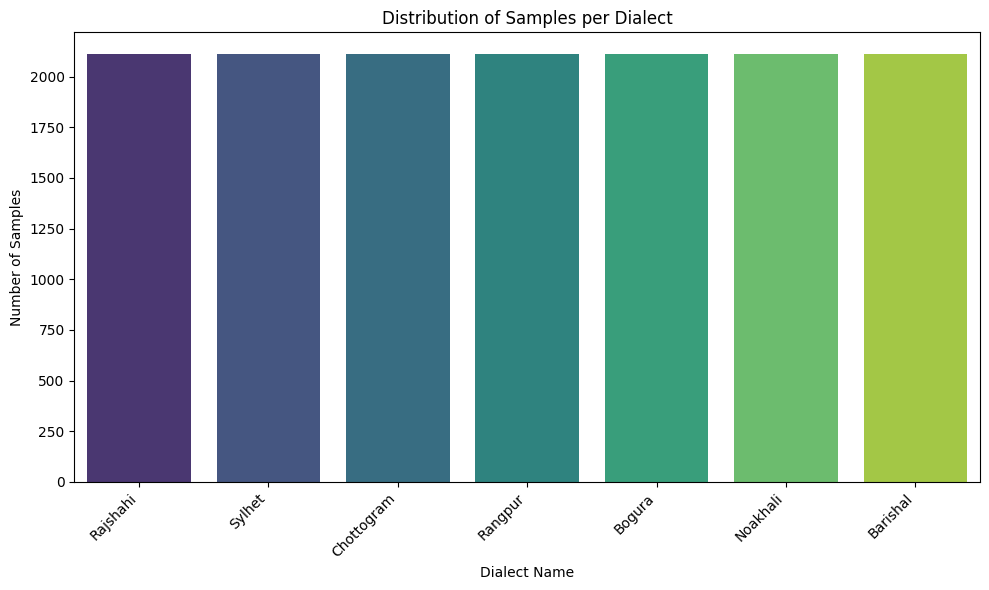

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=dialect_counts.index, y=dialect_counts.values, palette='viridis')
plt.title('Distribution of Samples per Dialect')
plt.xlabel('Dialect Name')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
The previous code generated a `FutureWarning` regarding the usage of `palette` in `sns.barplot`. To resolve this, I will update the `sns.barplot` call to explicitly set `hue` to the `dialect_counts.index` and `legend=False`, as recommended by the warning.



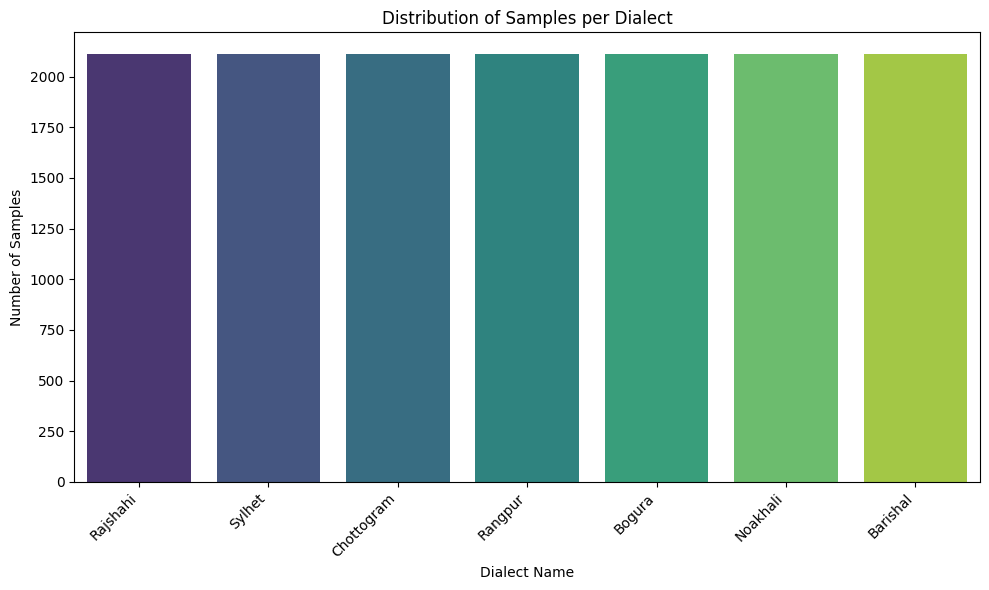

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=dialect_counts.index, y=dialect_counts.values, hue=dialect_counts.index, palette='viridis', legend=False)
plt.title('Distribution of Samples per Dialect')
plt.xlabel('Dialect Name')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Final Task

### Subtask:
Present the generated visualization and discuss any observations or insights regarding the dialect distribution.


## Summary:

### Data Analysis Key Findings
*   The dataset contains seven distinct dialects: 'Rajshahi', 'Sylhet', 'Chottogram', 'Rangpur', 'Bogura', 'Noakhali', and 'Barishal'.
*   Each of these seven dialects has an identical count of 2113 samples, indicating a perfectly balanced distribution across all dialects in the `data_long` DataFrame.
*   A bar chart was successfully generated to visualize this uniform distribution.

### Insights or Next Steps
*   The perfectly balanced distribution of samples across all dialects is ideal for machine learning tasks, as it prevents any single dialect from dominating the training data and potentially skewing model performance.
*   The next step could involve exploring the linguistic features or characteristics within each dialect to understand their unique properties, leveraging this balanced dataset for comparative analysis.
